<h3>MSA 8150 Final Project - Team 9

<h1>Predicting Shelter Animal Outcome

<img src="kaggle_pets2.png">

<h4>Team: </h4>
-Harini Devulapalli
-Krishna Prasad Pulipati
-Peiwen Liu
-Rajkiran Gaddati

<h4>Problem Description:</h4>
<p>https://www.kaggle.com/ has recently posted a competition on predicting adoption outcomes of shelter animals. According to the description, approximately 7.6 million companion animals end up in US shelters every year and 2.7 million of them are euthanized every year. The aim of the competition is to determine what factors influence these statistics and how animal shelters can improve the chances of an animal being adopted, such as spaying, naming, etc.
Our project aims to tackle this problem using the dataset provided by the Austin Animal Center. We plan to solve this problem in two different ways. First, as a classification problem, i.e. will the animal get adopted or not. Second, a regression problem, i.e. quantify the likelihood of adoption of an an animal.
We also aim to create a framework that can be used for any other datasets that have a combination of categorical and quantitative data, while providing an easy means for feature selection, comparison of various machine learning algorithms and selection of a final model.
</p>

<h4>Dataset:</h4>
<p>Our dataset contains the following data for a total of 26730 animals:
-AnimalID
-The Animal's name
-The time of the outcome
-OutcomeType - Categorical target variable
- AnimalType
-SexuponOutcome
-Age of the animal
-Breed
-Color


The dataset can be found at https://www.kaggle.com/c/shelter-animal-outcomes/data</p>


<h3>Data Preparation and Exploration

In [729]:
import pandas as pd
import numpy as np

Read files

In [730]:
df=pd.read_csv('./Downloads/AnimalTrain.csv')
df.fillna('',inplace=True)
df.drop_duplicates(inplace=True)
df_t=pd.read_csv('./Downloads/AnimalTest.csv')
df_t.fillna('',inplace=True)
df_t.drop_duplicates(inplace=True)

Data Exploration

In [731]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

In [732]:
#Function to plot counts
def countsPlotter(df,colName,title):
    data=df.groupby(colName)[colName].count()
    counts=data.values
    labels=list(data.index)
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, counts)
    plt.yticks(y_pos, labels)
    plt.xlabel('Count')
    plt.title(title)

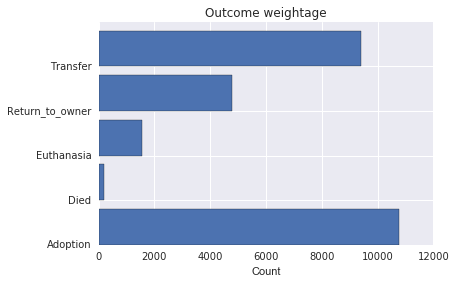

In [733]:
countsPlotter(df,'OutcomeType','Outcome weightage')

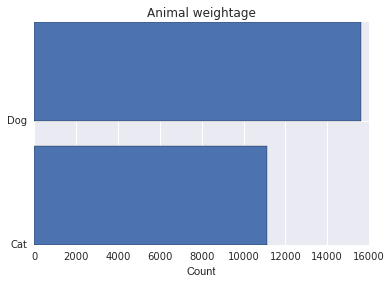

In [734]:
countsPlotter(df,u'AnimalType','Animal weightage')

<img src="overall.png">

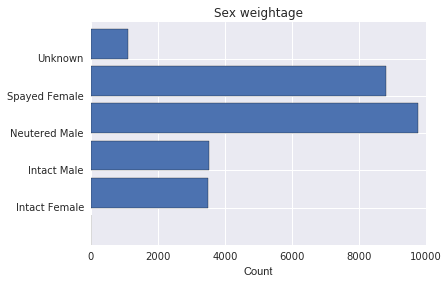

In [735]:
countsPlotter(df,u'SexuponOutcome','Sex weightage')

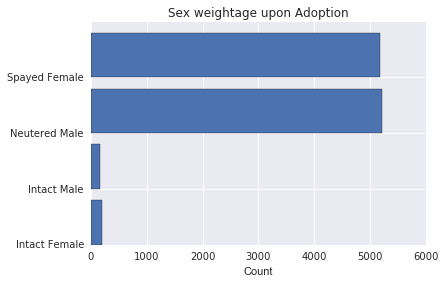

In [736]:
countsPlotter(df[df['OutcomeType']=='Adoption'],'SexuponOutcome','Sex weightage upon Adoption')

No. of breeds

In [737]:
len(df.groupby('Breed').groups.keys())

1380

Create short breed column (Only the first breed)

In [738]:
import re
def cleanStr(i):
    return re.sub('[^A-Za-z/]', ' ', i)

def split(i):
    iLst=cleanStr(i).split('/')
    end=iLst[0].find('Mix')
    if end==-1:
        return iLst[0]
    else:
        iLst[0]=iLst[0][:iLst[0].find('Mix')].strip()
        return iLst[0]

In [739]:
df['Breed']=[cleanStr(i) for i in df['Breed']]
df_t['Breed']=[cleanStr(i) for i in df_t['Breed']]

In [740]:
df['ShortBreed']=[split(str(i)) for i in df['Breed'].values]
df_t['ShortBreed']=[split(str(i)) for i in df_t['Breed'].values]

Get breed classes from wikipedia

In [741]:
url = 'https://en.wikipedia.org/wiki/List_of_dog_breeds_recognized_by_the_American_Kennel_Club'
# Scrape the HTML at the url
r = requests.get(url)

# Turn the HTML into a Beautiful Soup object
soup = BeautifulSoup(r.text,'lxml')

BreedWiki=[]

table = soup.find(id='mw-content-text')

# Find all the <tr> tag pairs, skip the first one, then for each.
for row in table.find_all('li'):
    # Create a variable of all the <td> tag pairs in each <tr> tag pair,
    BreedWiki.append(row.text)
BreedClass=[]
for i in BreedWiki:
    if i.find(',')!=-1:
        BreedClass.append(i)
BreedClass=BreedClass[:-1]

BreedClass=[i.split(',') for i in BreedClass]
BreedClass=pd.DataFrame(BreedClass,columns=['Breed','Class'])

In [742]:
df=pd.merge(df,BreedClass,how='left',left_on='ShortBreed',right_on='Breed')
df_t=pd.merge(df_t,BreedClass,how='left',left_on='ShortBreed',right_on='Breed')

In [743]:
df[u'Class'] = df[u'Class'].where(df[u'Class'].notnull(), df[u'ShortBreed'])
df_t[u'Class'] = df_t[u'Class'].where(df_t[u'Class'].notnull(), df_t[u'ShortBreed'])

In [744]:
def classEnd(i):
    if i.find('Terrier')!=-1 or i.find('Hound')!=-1 or i.find('Terr')!=-1 or i.find('Retriever')!=-1:
        return i.split(' ')[-1].strip()
    
    else:
        return i.strip()

In [745]:
df['Class']=[classEnd(i) for i in df['Class']]
df_t['Class']=[classEnd(i) for i in df_t['Class']]

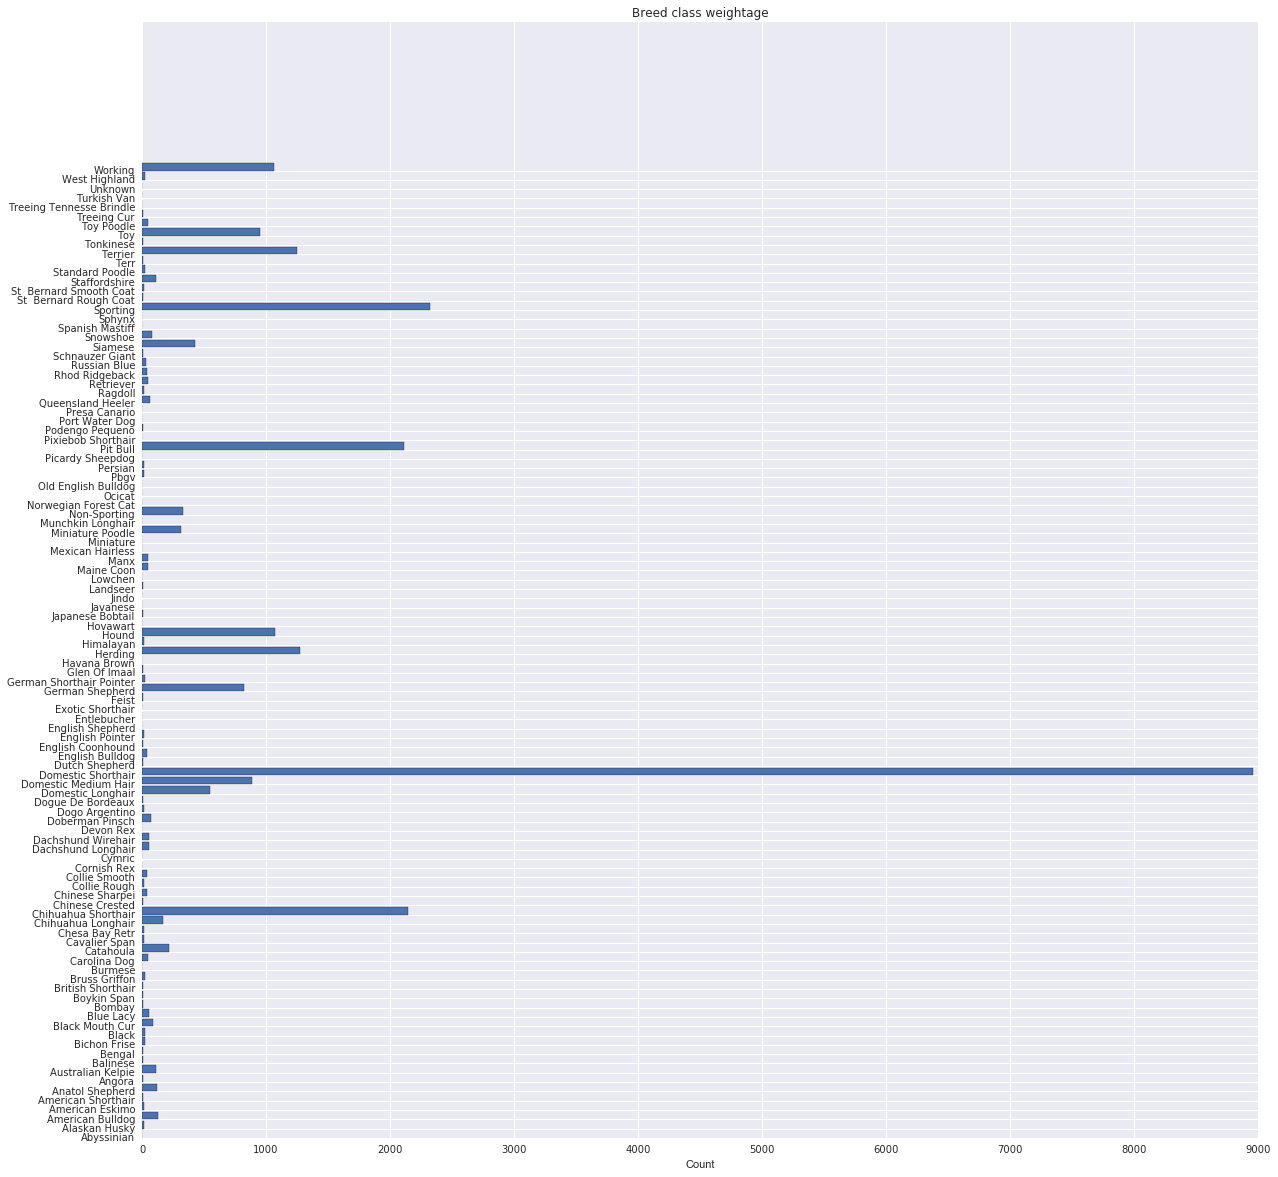

In [746]:
plt.figure(figsize=(20,20))
countsPlotter(df,'Class','Breed class weightage')

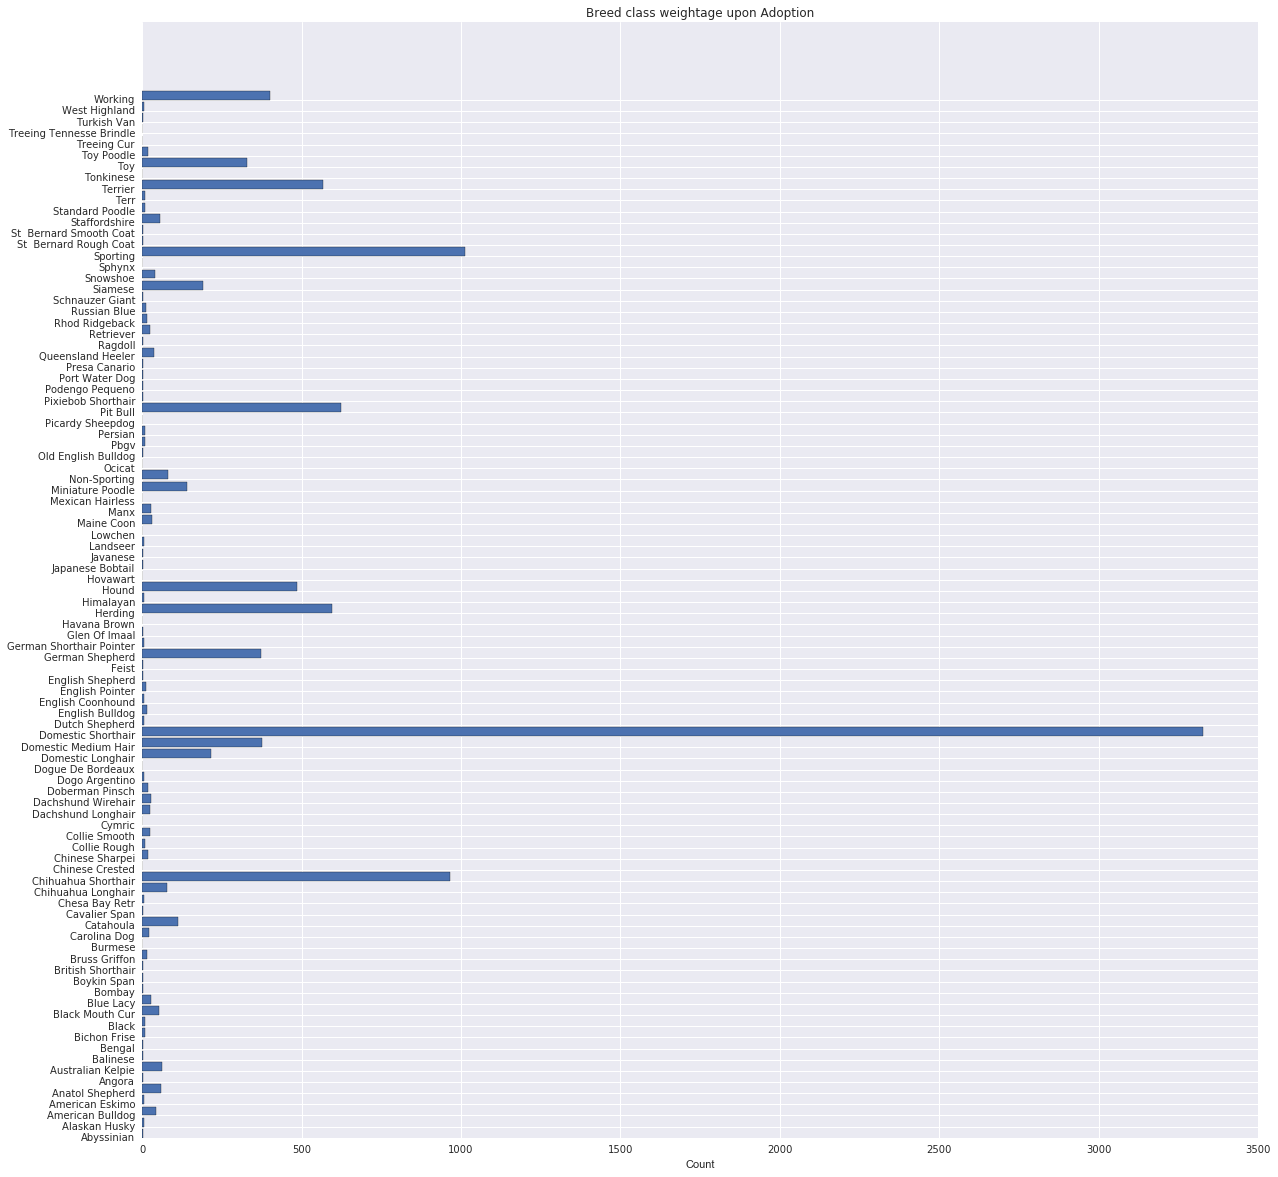

In [747]:
plt.figure(figsize=(20,20))
countsPlotter(df[df['OutcomeType']=='Adoption'],'Class','Breed class weightage upon Adoption')

Add Mixed breed feature

In [748]:
def mix(i):
    if i.find('Mix')!=-1 or i.find('/')!=-1:
        return 'Mix'
    else:
        return 'Pure'

In [749]:
df['Mix']=[mix(i) for i in df['Breed_x']]
df_t['Mix']=[mix(i) for i in df_t['Breed_x']]

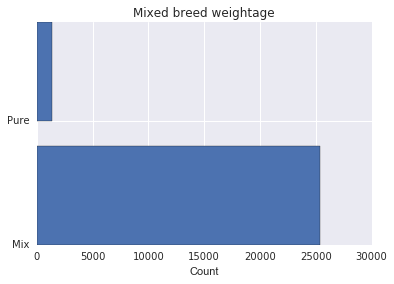

In [750]:
countsPlotter(df,'Mix','Mixed breed weightage')

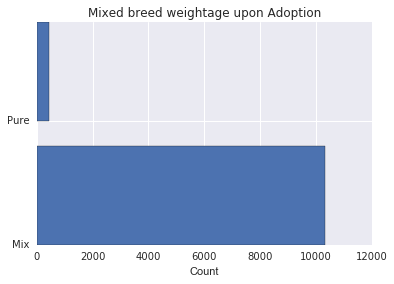

In [751]:
countsPlotter(df[(df['OutcomeType']=='Adoption')],'Mix','Mixed breed weightage upon Adoption')

Add Age

In [752]:
def toWeeks(age):
    age=str(age)
    ageSplt=age.split(' ')
    try:
        if ageSplt[1] in ['month','months']:
            return int(ageSplt[0])*4
        elif ageSplt[1] in ['year','years']:
            return int(ageSplt[0])*52
        elif ageSplt[1] in ['week','weeks']:
            return int(ageSplt[0])
        else: #assuming days
            return int(ageSplt[0])/7
    except:
        return -1

In [753]:
df['Age']=[toWeeks(age) for age in df['AgeuponOutcome']]
df_t['Age']=[toWeeks(age) for age in df_t['AgeuponOutcome']]

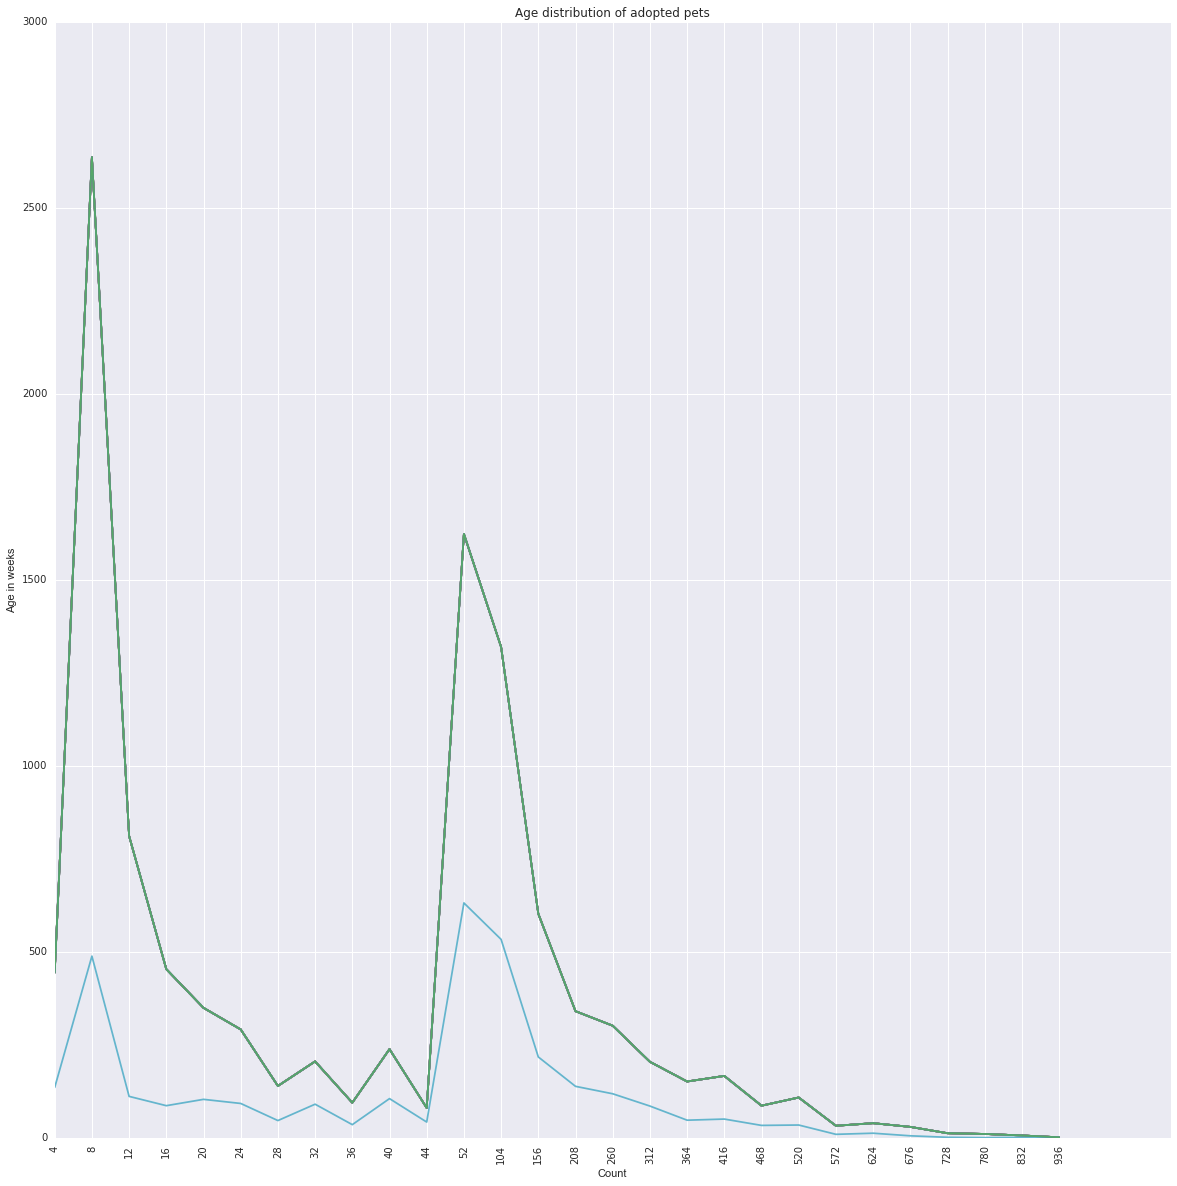

In [754]:
df1=df[df['OutcomeType']=='Adoption']
plt.figure(figsize=(20,20))
plt.plot(np.arange(len(df1.groupby('Age').count().index)),df1.groupby('Age').count().values)
plt.xticks(np.arange(len(df1.groupby('Age').count().index)),df1.groupby('Age').count().index,rotation='vertical')
plt.ylabel('Age in weeks')
plt.xlabel('Count')
plt.title('Age distribution of adopted pets')

<img src="babies.png">

Add intact and sex

In [755]:
def intact(i):
    if i.find('Intact')!=-1:
        return 'Intact'
    else:
        return 'Not'

In [756]:
def sex(i):
    if i.find('Male')!=-1:
        return 'Male'
    elif i.find('Female')!=-1:
        return 'Female'
    else:
        return 'Unknown'

In [757]:
df['Intact']=[intact(i) for i in df['SexuponOutcome']]
df_t['Intact']=[intact(i) for i in df_t['SexuponOutcome']]

In [758]:
df['Sex']=[sex(i) for i in df['SexuponOutcome']]
df_t['Sex']=[sex(i) for i in df_t['SexuponOutcome']]

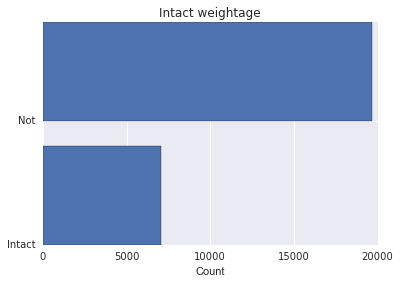

In [759]:
countsPlotter(df,'Intact','Intact weightage')

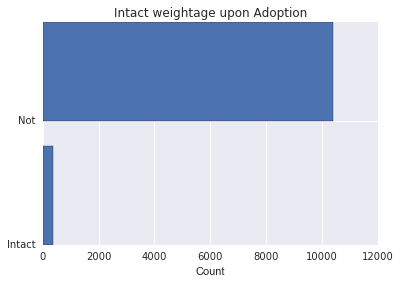

In [760]:
countsPlotter(df[(df['OutcomeType']=='Adoption')],'Intact','Intact weightage upon Adoption')

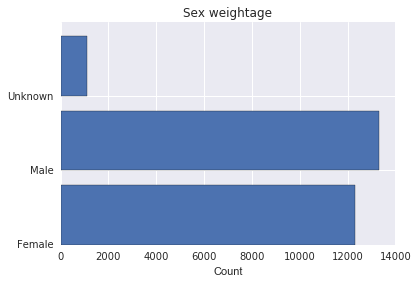

In [761]:
countsPlotter(df,'Sex','Sex weightage')

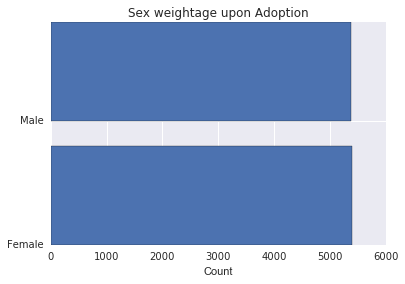

In [762]:
countsPlotter(df[(df['OutcomeType']=='Adoption')],'Sex','Sex weightage upon Adoption')

<img src="intact.png">

Add time features

In [763]:
df['Month']=pd.DatetimeIndex(df['DateTime']).month
df['Day']=pd.DatetimeIndex(df['DateTime']).day
df['Hour']=pd.DatetimeIndex(df['DateTime']).hour

In [764]:
df_t['Month']=pd.DatetimeIndex(df_t['DateTime']).month
df_t['Day']=pd.DatetimeIndex(df_t['DateTime']).day
df_t['Hour']=pd.DatetimeIndex(df_t['DateTime']).hour

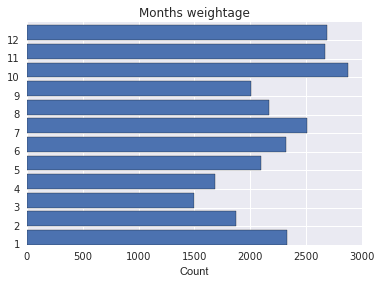

In [765]:
countsPlotter(df,'Month','Months weightage')

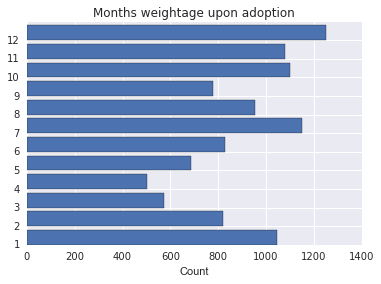

In [766]:
countsPlotter(df[(df['OutcomeType']=='Adoption')],'Month','Months weightage upon adoption')

<img src="times.png">

Add no-name feature

In [767]:
def noName(i):
    if i==np.nan or i=='':
        return 'No Name'
    else:
        return 'Name'

In [768]:
df['Named']=[noName(i) for i in df['Name']]
df_t['Named']=[noName(i) for i in df_t['Name']]

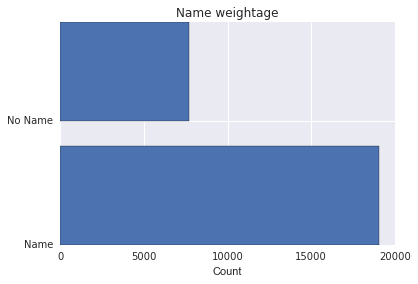

In [769]:
countsPlotter(df,'Named','Name weightage')

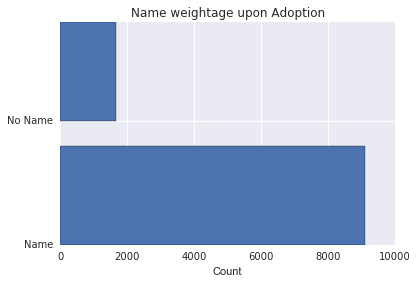

In [770]:
countsPlotter(df[df['OutcomeType']=='Adoption'],'Named','Name weightage upon Adoption')

Add color groups

In [771]:
def split2(i):
    return str(i).split('/')[0]   

In [772]:
df['ColorGroups']=[split2(i) for i in df['Color'].values]
df_t['ColorGroups']=[split2(i) for i in df_t['Color'].values]

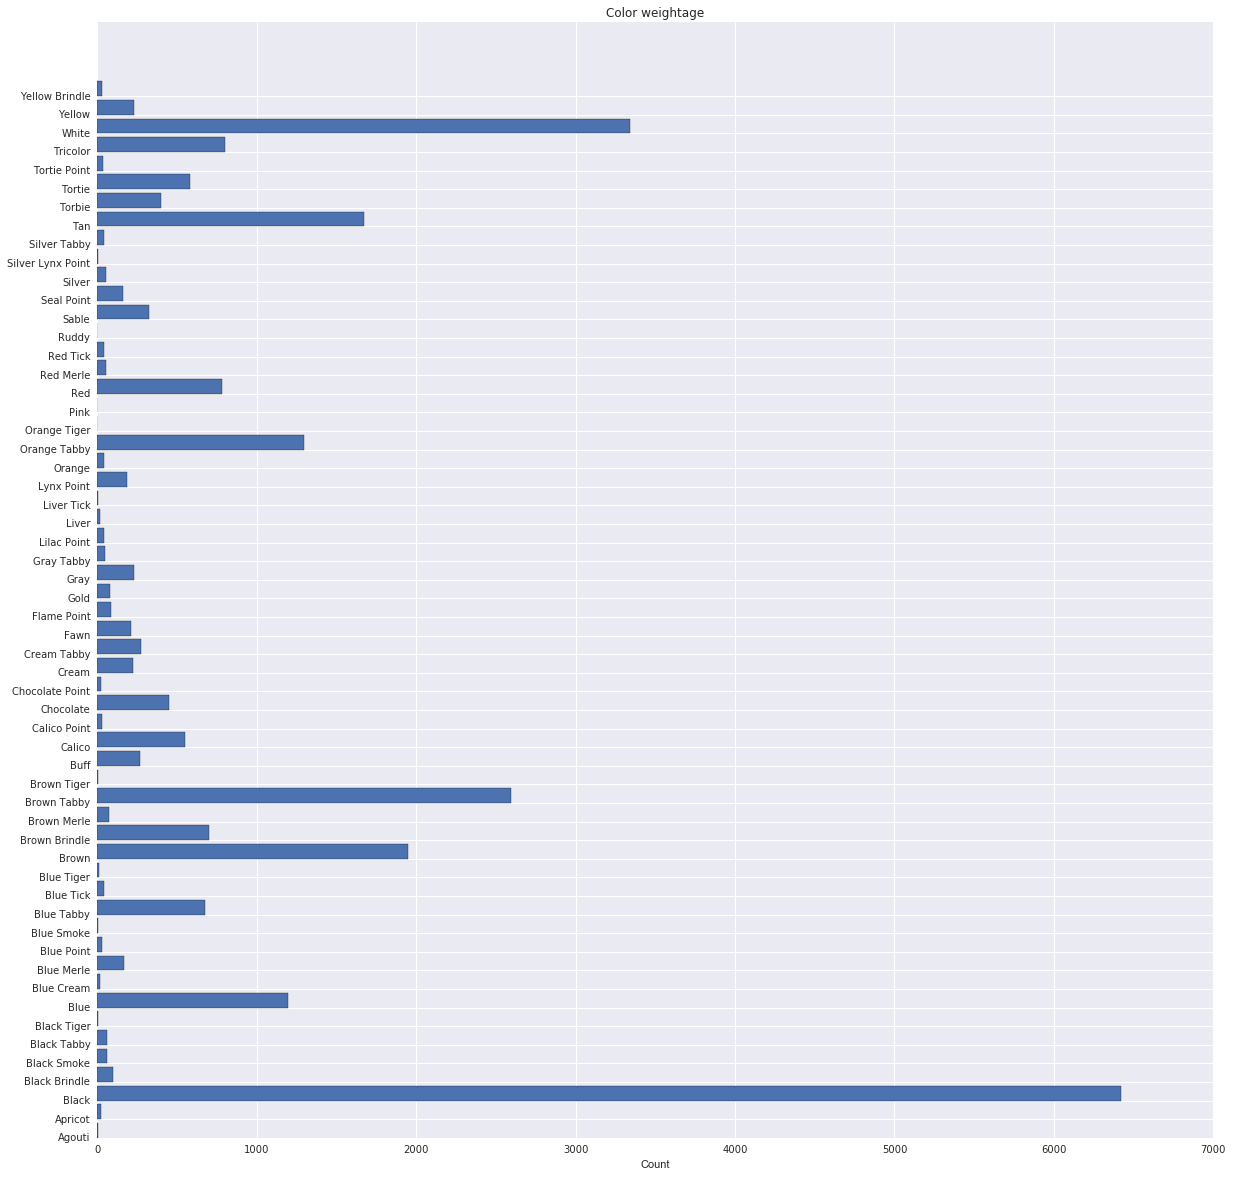

In [773]:
plt.figure(figsize=(20,20))
countsPlotter(df,'ColorGroups','Color weightage')

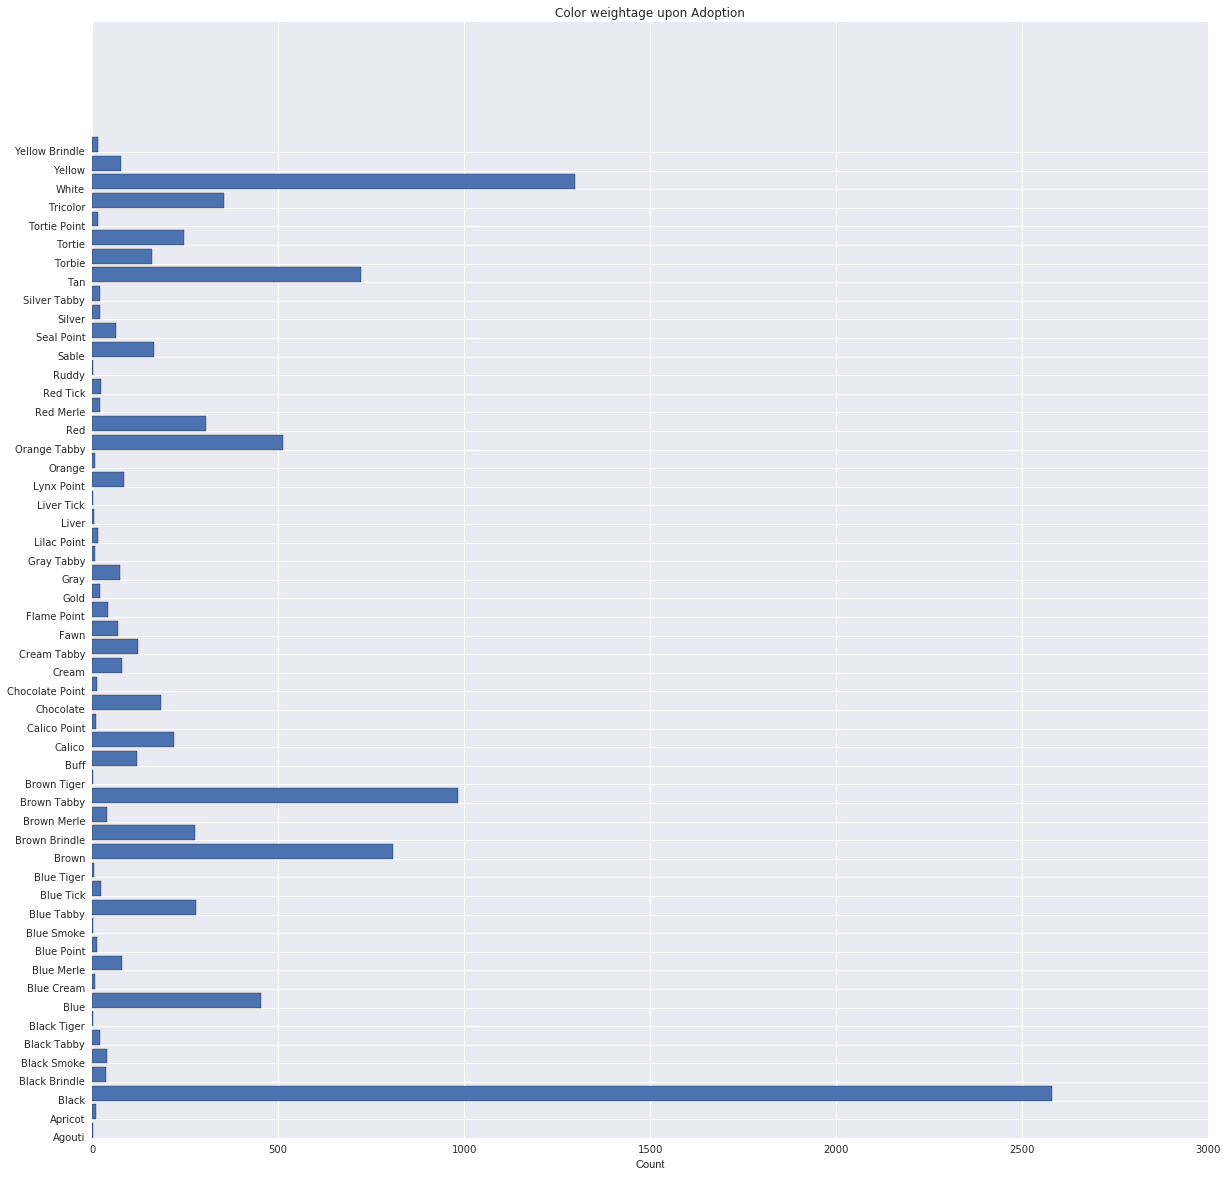

In [774]:
plt.figure(figsize=(20,20))
countsPlotter(df[df['OutcomeType']=='Adoption'],'ColorGroups','Color weightage upon Adoption')

Add weights

In [775]:
##Cats

url = 'http://www.petprescription.co.uk/healthcare/cat%20information%20/cat%20weight%20tables/'
# Scrape the HTML at the url
r = requests.get(url)

# Turn the HTML into a Beautiful Soup object
soup = BeautifulSoup(r.text,'lxml')

Adult_Male_Weight=[]
Breed=[]

table = soup.find('table')

# Find all the <tr> tag pairs, skip the first one, then for each.
for row in table.find_all('tr')[1:]:
    # Create a variable of all the <td> tag pairs in each <tr> tag pair,
    col = row.find_all('td')

    # Create a variable of the string inside 1st <td> tag pair,
    column_1 = col[0].text.strip()
    # and append it to first_name variable
    Breed.append(column_1)

    # Create a variable of the string inside 2nd <td> tag pair,
    column_2 = col[1].text.strip()
    # and append it to last_name variable
    Adult_Male_Weight.append(column_2)

columns = {'Breed': Breed, 'Adult_Male_Weight': Adult_Male_Weight }

df_weights_cats = pd.DataFrame(columns)

##Dogs

url = 'https://www.petcarerx.com/article/dog-breed-weight-chart/267'
# Scrape the HTML at the url
r = requests.get(url)

# Turn the HTML into a Beautiful Soup object
soup = BeautifulSoup(r.text,'lxml')

Adult_Male_Weight=[]
Breed=[]

table = soup.find('table')

# Find all the <tr> tag pairs, skip the first one, then for each.
for row in table.find_all('tr')[1:]:
    # Create a variable of all the <td> tag pairs in each <tr> tag pair,
    col = row.find_all('td')

    # Create a variable of the string inside 1st <td> tag pair,
    column_1 = col[0].text.strip()
    # and append it to first_name variable
    Breed.append(column_1)

    # Create a variable of the string inside 2nd <td> tag pair,
    column_2 = col[1].text.strip()
    # and append it to last_name variable
    Adult_Male_Weight.append(column_2)

columns = {'Breed': Breed, 'Adult_Male_Weight': Adult_Male_Weight }

df_weights_dogs = pd.DataFrame(columns)
    
frames =[df_weights_cats,df_weights_dogs]

df_weights= pd.concat(frames)

In [776]:
def avgWeights(i):
    i=re.sub('[^0-9]',' ',i)
    i=re.sub(' +',' ',i)
    i=i.strip()
    iLst=i.split(' ')
    for i in range(len(iLst)):
        iLst[i]=int(iLst[i])
    return np.mean(iLst)

In [777]:
df_weights['Adult_Male_Weight']=[avgWeights(i) for i in df_weights['Adult_Male_Weight'].values]

In [778]:
df=pd.merge(df,df_weights,how='left',left_on='ShortBreed',right_on='Breed')
df_t=pd.merge(df_t,df_weights,how='left',left_on='ShortBreed',right_on='Breed')

In [779]:
df.fillna(0,inplace=True)
df_t.fillna(0,inplace=True)

In [780]:
df['Adult_Male_Weight'] = df['Adult_Male_Weight'].where(df['Adult_Male_Weight']!=0, np.mean(df['Adult_Male_Weight'].values))
df_t['Adult_Male_Weight'] = df_t['Adult_Male_Weight'].where(df_t['Adult_Male_Weight']!=0, np.mean(df_t['Adult_Male_Weight'].values))

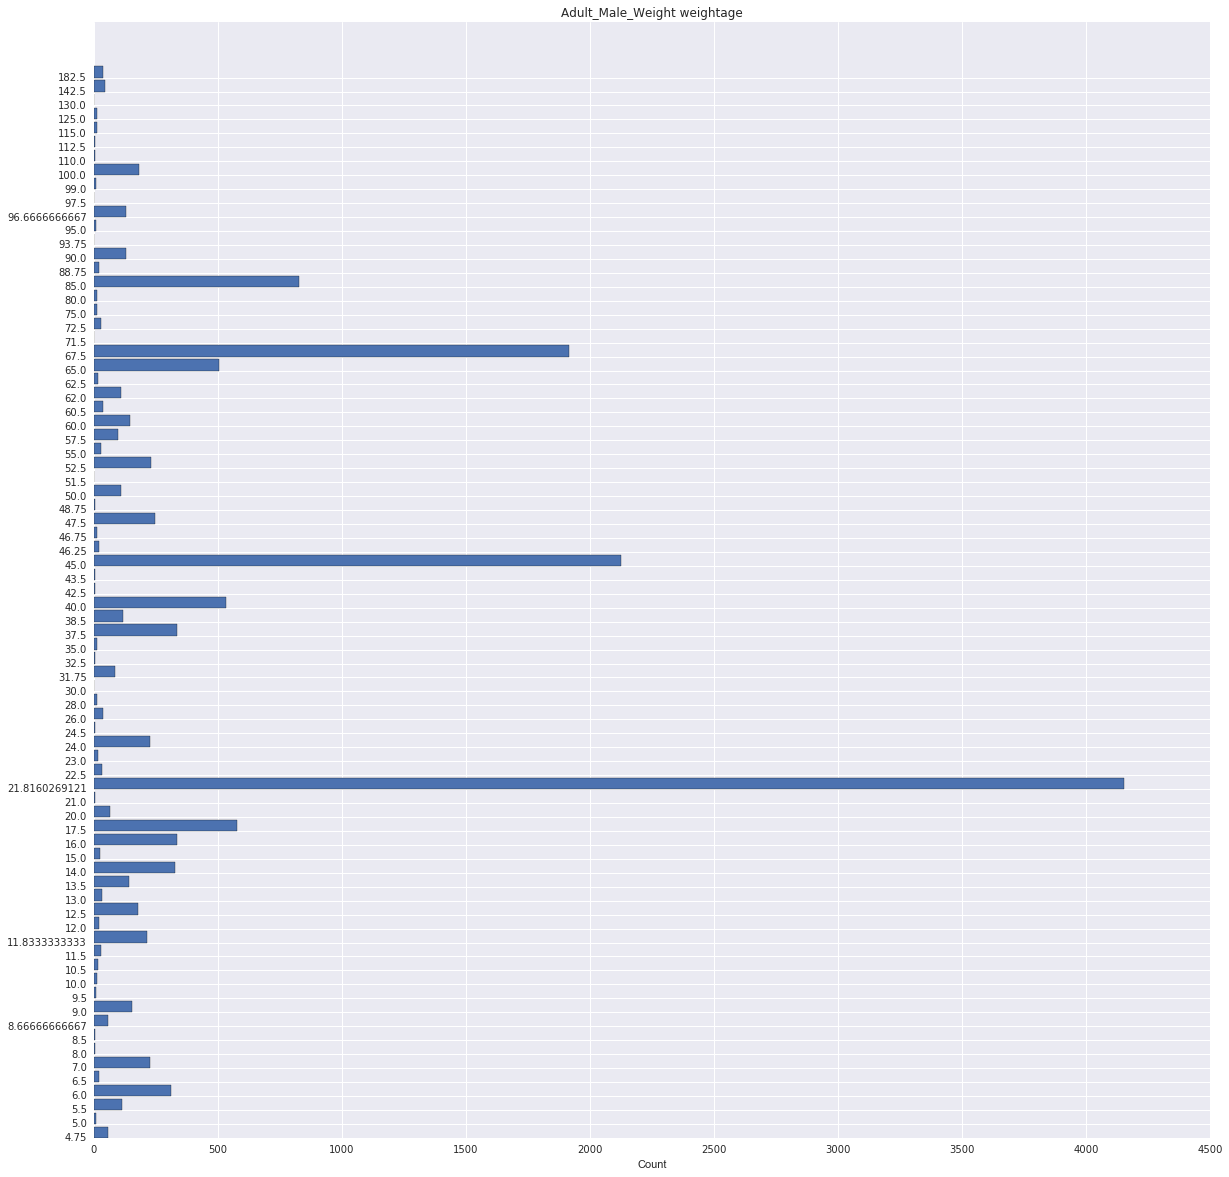

In [781]:
plt.figure(figsize=(20,20))
countsPlotter(df[(df['AnimalType']=='Dog')],'Adult_Male_Weight','Adult_Male_Weight weightage')

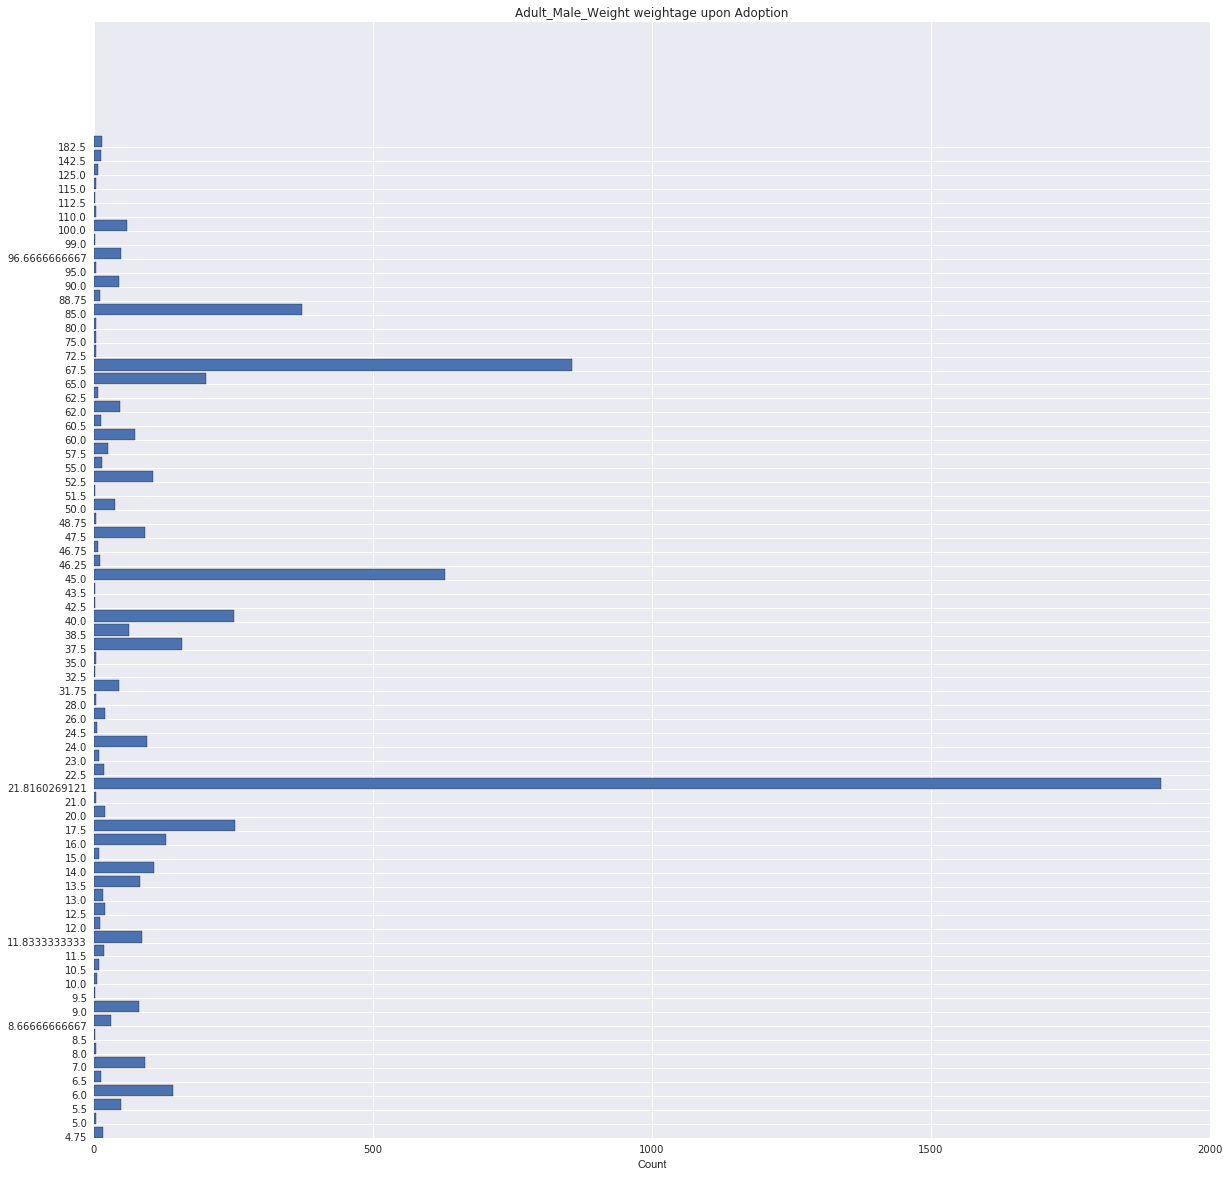

In [782]:
plt.figure(figsize=(20,20))
countsPlotter(df[(df['OutcomeType']=='Adoption') & (df['AnimalType']=='Dog')],'Adult_Male_Weight','Adult_Male_Weight weightage upon Adoption')

Drop unused columns

In [783]:
df.columns

Index([u'AnimalID', u'Name', u'DateTime', u'OutcomeType', u'OutcomeSubtype',
       u'AnimalType', u'SexuponOutcome', u'AgeuponOutcome', u'Breed_x',
       u'Color', u'ShortBreed', u'Breed_y', u'Class', u'Mix', u'Age',
       u'Intact', u'Sex', u'Month', u'Day', u'Hour', u'Named', u'ColorGroups',
       u'Adult_Male_Weight', u'Breed'],
      dtype='object')

In [784]:
df.drop(['DateTime','Name','OutcomeSubtype','SexuponOutcome','AgeuponOutcome',u'Color',u'Breed_y',u'Breed_x',u'Breed'],axis=1,inplace=True)
df_t.drop(['DateTime','Name','SexuponOutcome','AgeuponOutcome',u'Color',u'Breed_y',u'Breed_x',u'Breed'],axis=1,inplace=True)

<h3>Labelling and training our mobel

Labeller

In [785]:
from sklearn.preprocessing import LabelEncoder

def labeller(df,lstColNames):
    labelLst=[]
    for i in lstColNames:
        labelLst.append(LabelEncoder())
        labelLst[-1].fit(df[i].values)
    return labelLst

In [786]:
labelLst=labeller(df,[u'OutcomeType', u'AnimalType', u'ShortBreed',u'Class', u'Mix', u'Intact', u'Sex',u'Named', u'ColorGroups'])

In [787]:
Breeds=pd.concat([df_t[u'ShortBreed'],df[u'ShortBreed']])
Classes=pd.concat([df_t[u'Class'],df[u'Class']])

In [788]:
labelLst[2].fit(Breeds.values)
labelLst[3].fit(Classes.values)

LabelEncoder()

In [789]:
def labelDF(df,lstColNames,labelLst,t=False):
    df_label=pd.DataFrame()
    if t==True:
        labelLst=labelLst[1:]
    for k,i in enumerate(lstColNames):
        df_label[i]=labelLst[k].transform(df[i])
    return df_label

In [790]:
df_label=pd.merge(df[['AnimalID','Age',u'Month', u'Day', u'Hour',u'Adult_Male_Weight']],labelDF(df,[u'OutcomeType', u'AnimalType', u'ShortBreed',u'Class', u'Mix', u'Intact', u'Sex',u'Named', u'ColorGroups'],labelLst),how='inner',left_index=True,right_index=True)
df_label_t=pd.merge(df_t[['ID','Age',u'Month', u'Day', u'Hour',u'Adult_Male_Weight']],labelDF(df_t,[ u'AnimalType', u'ShortBreed',u'Class', u'Mix', u'Intact', u'Sex',u'Named', u'ColorGroups'],labelLst,True),how='inner',left_index=True,right_index=True)

In [791]:
df_label.columns

Index([         u'AnimalID',               u'Age',             u'Month',
                     u'Day',              u'Hour', u'Adult_Male_Weight',
             u'OutcomeType',        u'AnimalType',        u'ShortBreed',
                   u'Class',               u'Mix',            u'Intact',
                     u'Sex',             u'Named',       u'ColorGroups'],
      dtype='object')

<h3>PCA Experiments

In [792]:
Y=df_label['OutcomeType'].values

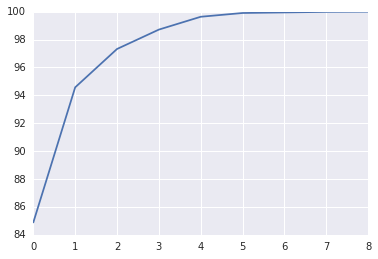

In [793]:
from sklearn.decomposition import PCA

pca = PCA(n_components=9,copy=False)
pca.fit(df_label.ix[:,1:])
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

(-0.2, 17)

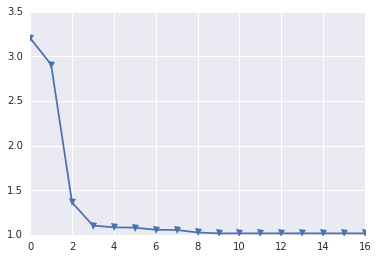

In [798]:
df_new=pca.fit_transform(scale(df_label.ix[:,1:]))

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set_style('darkgrid')
n = len(df_new)
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=2)
regr = LinearRegression()
mse = []

score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), Y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score) 

for i in np.arange(1,17):
    score = -1*cross_validation.cross_val_score(regr, df_new[:,:i], Y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)

#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
#ax1.plot(mse, '-v')
#ax2.plot([1,2,3,4,5,6,7,8,9], mse[1:10], '-v')
#ax2.set_title('Intercept excluded from plot')
plt.plot( np.array(mse), '-v')
#for ax in fig.axes:
ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_xlim((-0.2,17))

Transpose the target to the format required by kaggle.com

(-0.2, 14)

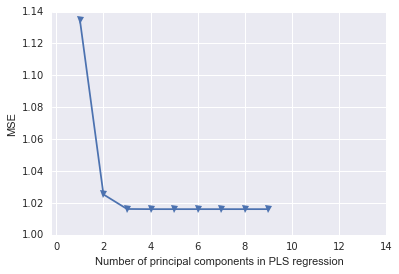

In [799]:
from sklearn.cross_decomposition import PLSRegression
mse = []

kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=2)

for i in np.arange(1,10):
    pls = PLSRegression(n_components=i, scale=False)
    pls.fit(scale(df_new),Y)
    score = cross_validation.cross_val_score(pls, df_new , Y, cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 10), np.array(mse), '-v')
plt.xlabel('Number of principal components in PLS regression')
plt.ylabel('MSE')
plt.xlim((-0.2, 14))


In [800]:
df_new=df_label[[u'AnimalID',u'OutcomeType']]
df_new['B']=[1]*len(df_new)
df_new=df_new.pivot_table('B' ,'AnimalID' ,'OutcomeType')
df_new.fillna(0,inplace=True)
df_new['AnimalID']=df_new.index

/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [801]:
df_label=pd.merge(df_label,df_new,how='inner',on='AnimalID')
df_label.drop('OutcomeType',inplace=True,axis=1)

In [802]:
df_label.rename(columns={0: 'Adoption',1:'Died',2:'Euthanasia',3:'Return_to_owner',4:'Transfer','Adult_Male_Weight':'Adult_Weight','AnimalID':'ID'}, inplace=True)

In [803]:
df_label_t.rename(columns={'Adult_Male_Weight':'Adult_Weight'}, inplace=True)

In [817]:
X=df_label[[u'Age',           u'Month',
                   u'Day',            u'Hour',    u'Adult_Weight',
            u'AnimalType',      u'ShortBreed',           u'Class',
                   u'Mix',          u'Intact',             u'Sex',
                 u'Named',     u'ColorGroups']].as_matrix()
y=df_label[[u'Adoption',
                  u'Died',      u'Euthanasia', u'Return_to_owner',
              u'Transfer']].as_matrix()

In [697]:
corr=df_label.corr()[:-5]
corr[[u'Adoption',u'Died',u'Euthanasia', u'Return_to_owner',
              u'Transfer']]

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
Age,-0.147945,-0.023626,0.150135,0.307838,-0.164486
Month,0.018345,0.000579,-0.005373,-0.033903,0.010903
Day,0.006693,-0.004916,-0.003006,-0.014612,0.007208
Hour,0.239774,-0.064975,-0.053093,0.058372,-0.255362
Adult_Weight,0.010620,-0.034618,0.009609,0.211847,-0.179424
AnimalType,0.033087,-0.057618,-0.020186,0.295644,-0.251020
ShortBreed,-0.034821,-0.011382,0.038233,0.092776,-0.055400
Class,-0.015857,-0.029593,0.004819,0.178327,-0.123893
Mix,-0.040327,-0.004435,-0.012178,0.083884,-0.019155
Intact,0.428469,-0.082579,-0.170094,0.106766,-0.427445


In [805]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [806]:
X_T=df_label_t[[u'Age',           u'Month',
                   u'Day',            u'Hour',    u'Adult_Weight',
            u'AnimalType',      u'ShortBreed',           u'Class',
                   u'Mix',          u'Intact',             u'Sex',
                 u'Named',     u'ColorGroups']].as_matrix()

<h3>Prediction time!

In [816]:
def kagglePredict(modeltype,X_train,y_train,X_test,colLst):
    y_pred=pd.DataFrame()
    y_train=y_train.reshape(y_train.shape[1],y_train.shape[0])
    modelLst=[]
    for i in range(y_train.shape[0]):
        modelLst.append(modeltype)
        modelLst[-1].fit(X_train,y_train[i])
        y_pred[colLst[i]]=modelLst[-1].predict(X_test)
    return y_pred
    

<H4>Random Forests

In [808]:
from sklearn.ensemble import RandomForestClassifier
y_pred=kagglePredict(RandomForestClassifier(n_jobs=4),X_train,y_train,X_test,y_test,[u'Adoption',u'Died',u'Euthanasia', u'Return_to_owner',
              u'Transfer'])

<H4>Metrics: Only for Classification algorithms

In [809]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
%matplotlib inline
def plotCM(cm,title,cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')

def confusion(test,pred,title):
    print confusion_matrix(test,pred)
    print 'Precision, Recall, F-Score and Support'
    print precision_recall_fscore_support(test, pred, average='macro')
    print 'Accuracy'
    print accuracy_score(test, pred)
    plotCM(confusion_matrix(test,pred),'CM '+title)

[[5044  200]
 [3463  114]]
Precision, Recall, F-Score and Support
(0.36305732484076431, 0.03187028235951915, 0.058596761757902849, None)
Accuracy
0.584740959075


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


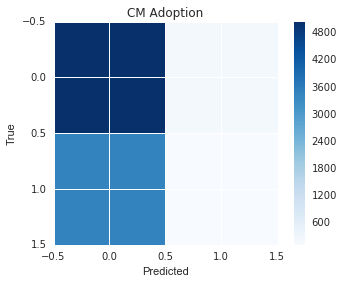

In [810]:
confusion(y_test[:,0],y_pred['Adoption'].as_matrix(),'Adoption')

[[8470  295]
 [  53    3]]
Precision, Recall, F-Score and Support
(0.010067114093959731, 0.053571428571428568, 0.016949152542372881, None)
Accuracy
0.960548690625


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


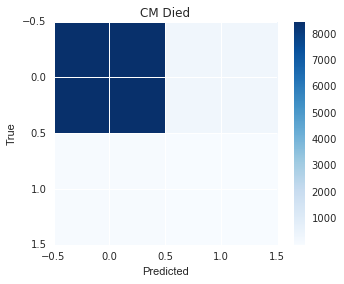

In [811]:
confusion(y_test[:,1],y_pred['Died'].as_matrix(),'Died')

[[7981  334]
 [ 496   10]]
Precision, Recall, F-Score and Support
(0.029069767441860465, 0.019762845849802372, 0.023529411764705882, None)
Accuracy
0.905906359823


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


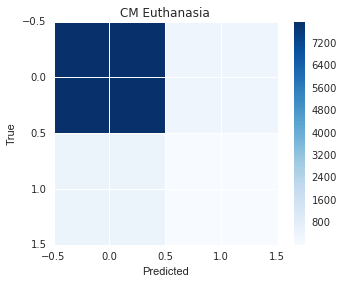

In [812]:
confusion(y_test[:,2],y_pred['Euthanasia'].as_matrix(),'Euthanasia')

[[6960  284]
 [1526   51]]
Precision, Recall, F-Score and Support
(0.15223880597014924, 0.032339885859226376, 0.053347280334728034, None)
Accuracy
0.794807844916


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


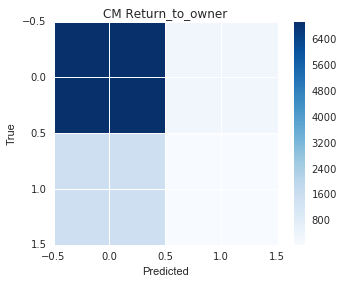

In [813]:
confusion(y_test[:,3],y_pred['Return_to_owner'].as_matrix(),'Return_to_owner')

[[5527  189]
 [2963  142]]
Precision, Recall, F-Score and Support
(0.42900302114803623, 0.045732689210950084, 0.082654249126891732, None)
Accuracy
0.642670898991


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


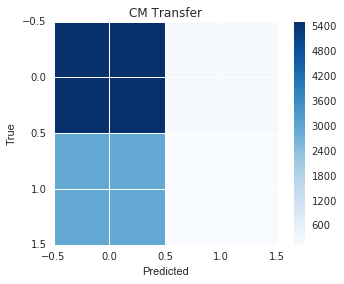

In [814]:
confusion(y_test[:,4],y_pred['Transfer'].as_matrix(),'Transfer')

Try a few more

[[4961  283]
 [3432  145]]
Precision, Recall, F-Score and Support
(0.33878504672897197, 0.040536762650265588, 0.072409488139825229, None)
Accuracy
0.578845935835


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


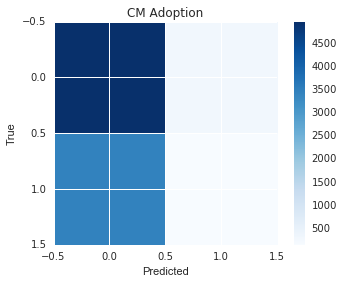

In [820]:
from sklearn.ensemble import ExtraTreesClassifier

y_pred=kagglePredict(ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=1, random_state=0),X_train,y_train,X_test,[u'Adoption',u'Died',u'Euthanasia', u'Return_to_owner',
              u'Transfer'])
confusion(y_test[:,0],y_pred['Adoption'].as_matrix(),'Adoption')

[[5243    1]
 [3576    1]]
Precision, Recall, F-Score and Support
(0.5, 0.00027956388034665921, 0.00055881531153953619, None)
Accuracy
0.594490420587


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


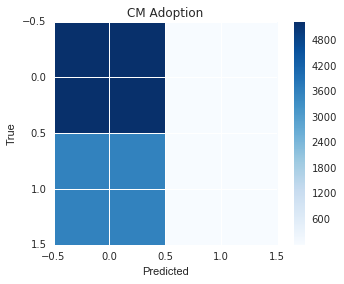

In [821]:
from sklearn.ensemble import AdaBoostClassifier

y_pred=kagglePredict(AdaBoostClassifier(n_estimators=100),X_train,y_train,X_test,[u'Adoption',u'Died',u'Euthanasia', u'Return_to_owner',
              u'Transfer'])
confusion(y_test[:,0],y_pred['Adoption'].as_matrix(),'Adoption')

[[5244    0]
 [3576    1]]
Precision, Recall, F-Score and Support
(1.0, 0.00027956388034665921, 0.00055897149245388487, None)
Accuracy
0.594603786419


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


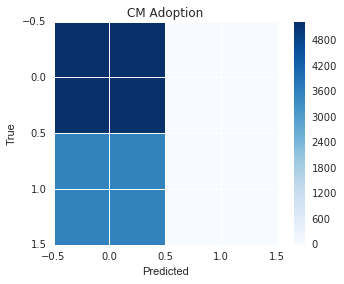

In [822]:
from sklearn.ensemble import GradientBoostingClassifier

y_pred=kagglePredict(GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, random_state=0),X_train,y_train,X_test,[u'Adoption',u'Died',u'Euthanasia', u'Return_to_owner',
              u'Transfer'])
confusion(y_test[:,0],y_pred['Adoption'].as_matrix(),'Adoption')

[[5229   15]
 [3558   19]]
Precision, Recall, F-Score and Support
(0.55882352941176472, 0.0053117137265865253, 0.010523400720022155, None)
Accuracy
0.594943883913


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


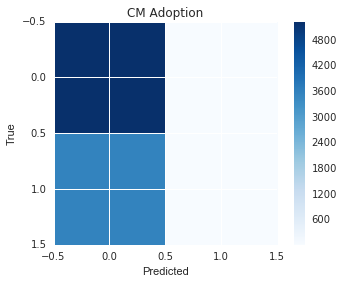

In [823]:
from sklearn.neighbors import KNeighborsClassifier

y_pred=kagglePredict(KNeighborsClassifier(n_neighbors=15),X_train,y_train,X_test,[u'Adoption',u'Died',u'Euthanasia', u'Return_to_owner',
              u'Transfer'])
confusion(y_test[:,0],y_pred['Adoption'].as_matrix(),'Adoption')

In [828]:
performance=pd.DataFrame({'Algorithm':['RandomForestClassifier',
                         'ExtraTreesClassifier',
                         'AdaBoostClassifier',
                         'GradientBoostingClassifier',
                         'KNeighborsClassifier'],
                         'Accuracy':[58,57.8,59.4,59.4,59.5]})

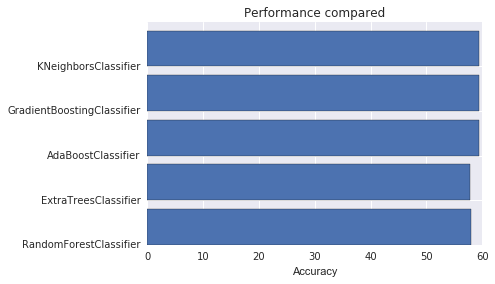

In [830]:
counts=performance['Accuracy'].values
labels=performance['Algorithm'].values.tolist()
y_pos = np.arange(len(labels))
plt.barh(y_pos, counts)
plt.yticks(y_pos, labels)
plt.xlabel('Accuracy')
plt.title('Performance compared')

For the final submission

In [825]:
from sklearn.ensemble import GradientBoostingRegressor
y_pred=kagglePredict(GradientBoostingRegressor(random_state=0, n_estimators=500,learning_rate=0.1),X,y,X_T,[u'Adoption',u'Died',u'Euthanasia', u'Return_to_owner',
              u'Transfer'])

In [826]:
sub=pd.DataFrame({'ID': df_label_t['ID'].values,
        'Adoption' : y_pred['Adoption'].values,
             'Died':y_pred['Died'].values,
             'Euthanasia': y_pred['Euthanasia'].values,
             'Return_to_owner': y_pred['Return_to_owner'].values,
             'Transfer': y_pred['Transfer'].values})
sub.to_csv('AnimalSub.csv',index=False)

<h3>Results

Kaggle leader board:
- Best score: 0.45175
- Our Score: 1.43460
- All adopted benchmark: 20.25113